## Is it a bird?

In [2]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [3]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ypy-websocket 0.8.2 requires aiofiles<23,>=22.1.0, but you have aiofiles 23.1.0 which is incompatible.


In [4]:
import torch
# !watch -n 1 nvidia-smi
torch.cuda.is_available()

True

In 2015 the idea of creating a computer system that could recognise birds was considered so outrageously challenging that it was the basis of [this XKCD joke](https://xkcd.com/1425/):

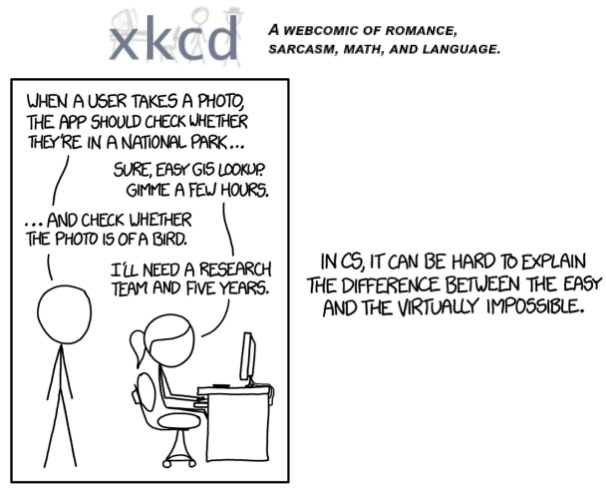

But today, we can do exactly that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "bird photos"
1. Use DuckDuckGo to search for images of "forest photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

## Step 1: Download images of birds and non-birds

In [5]:
data_path = "../input/dogbreeds/all"

In [6]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [7]:
urls = search_images('Affenpinscher photos', max_images=10)
for url in urls:
    print(url)

Searching for 'Affenpinscher photos'


/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


https://img.dog-learn.com/dog-breeds/affenpinscher/images/affenpinscher-black-cc-sz3.jpg
http://www.dog-learn.com/dog-breeds/affenpinscher/images/affenpinscher-dog-cc.jpg
http://www.dogalize.com/wp-content/uploads/2016/12/Affenpinscher.jpg
http://www.photos-de-chiens.fr/files/2014/11/affenpinscher.jpg
http://animalsbreeds.com/wp-content/uploads/2014/09/Affenpinscher-2.jpg
https://hypoallergenicdog.net/wp-content/uploads/2020/05/Black-Fluffy-Affenpinschers.jpg
https://www.mascotarios.org/wp-content/gallery/affenpinscher/affenpinscher8.jpg
https://i1.wp.com/www.mascotarios.org/wp-content/uploads/2011/04/affenpinscher1.jpg
https://www.thekennelclub.org.uk/media/1599/affenpinscher-standing.jpg?mode=pad&width=1000&rnd=132143801920000000
http://fishsubsidy.org/wp-content/uploads/2020/01/affenpinscher-1.jpg


...and then download a URL and take a look at it:

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


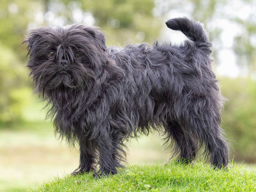

In [8]:
from fastdownload import download_url
dest = 'dog1.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "forest photos":

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "bird" and "forest" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [9]:
import os

NUM_IMAGES_PER_CLASS = 100
searches = ['Affenpinscher', 'Afghan hound', 'Airedale terrier', 'Akita', 'Alaskan malamute', 'American eskimo dog', 'American foxhound', 'American staffordshire terrier', 'American water spaniel', 'Anatolian shepherd dog', 'Australian cattle dog', 'Australian shepherd', 'Australian terrier', 'Basenji', 'Basset hound', 'Beagle', 'Bearded collie', 'Beauceron', 'Bedlington terrier', 'Belgian malinois', 'Belgian sheepdog', 'Belgian tervuren', 'Bernese mountain dog', 'Bichon frise', 'Black and tan coonhound', 'Black russian terrier', 'Bloodhound', 'Bluetick coonhound', 'Border collie', 'Border terrier', 'Borzoi', 'Boston terrier', 'Bouvier des flandres', 'Boxer', 'Boykin spaniel', 'Briard', 'Brittany', 'Brussels griffon', 'Bull terrier', 'Bulldog', 'Bullmastiff', 'Cairn terrier', 'Canaan dog', 'Cane corso', 'Cardigan welsh corgi', 'Cavalier king charles spaniel', 'Chesapeake bay retriever', 'Chihuahua', 'Chinese crested', 'Chinese shar-pei', 'Chow chow', 'Clumber spaniel', 'Cocker spaniel', 'Collie', 'Curly-coated retriever', 'Dachshund', 'Dalmatian', 'Dandie dinmont terrier', 'Doberman pinscher', 'Dogue de bordeaux', 'English cocker spaniel', 'English setter', 'English springer spaniel', 'English toy spaniel', 'Entlebucher mountain dog', 'Field spaniel', 'Finnish spitz', 'Flat-coated retriever', 'French bulldog', 'German pinscher', 'German shepherd dog', 'German shorthaired pointer', 'German wirehaired pointer', 'Giant schnauzer', 'Glen of imaal terrier', 'Golden retriever', 'Gordon setter', 'Great dane', 'Great pyrenees', 'Greater swiss mountain dog', 'Greyhound', 'Havanese', 'Ibizan hound', 'Icelandic sheepdog', 'Irish red and white setter', 'Irish setter', 'Irish terrier', 'Irish water spaniel', 'Irish wolfhound', 'Italian greyhound', 'Japanese chin', 'Keeshond', 'Kerry blue terrier', 'Komondor', 'Kuvasz', 'Labrador retriever', 'Lakeland terrier', 'Leonberger', 'Lhasa apso', 'Lowchen', 'Maltese', 'Manchester terrier', 'Mastiff', 'Miniature schnauzer', 'Neapolitan mastiff', 'Newfoundland', 'Norfolk terrier', 'Norwegian buhund', 'Norwegian elkhound', 'Norwegian lundehund', 'Norwich terrier', 'Nova scotia duck tolling retriever', 'Old english sheepdog', 'Otterhound', 'Papillon', 'Parson russell terrier', 'Pekingese', 'Pembroke welsh corgi', 'Petit basset griffon vendeen', 'Pharaoh hound', 'Plott', 'Pointer', 'Pomeranian', 'Poodle', 'Portuguese water dog', 'Saint bernard', 'Silky terrier', 'Smooth fox terrier', 'Tibetan mastiff', 'Welsh springer spaniel', 'Wirehaired pointing griffon', 'Xoloitzcuintli', 'Yorkshire terrier']
path = Path(data_path)
from time import sleep

for o in searches:
    dest = (path/o.replace(" ", "_"))
#     print(dest)
#     dest.mkdir(exist_ok=True, parents=True)
    num_images_in_class = len(os.listdir(dest))
    print(f"Class {o}: {num_images_in_class} training images.")
#     if num_images_in_class < NUM_IMAGES_PER_CLASS:
#         download_images(dest, urls=search_images(f'{o} photo', max_images=))
#     sleep(10)  # Pause between searches to avoid over-loading server
#     download_images(dest, urls=search_images(f'{o} sun photo'))
#     sleep(10)
#     download_images(dest, urls=search_images(f'{o} shade photo'))
#     sleep(10)
#     resize_images(path/o, max_size=400, dest=path/o)

Class Affenpinscher: 80 training images.
Class Afghan hound: 73 training images.
Class Airedale terrier: 65 training images.
Class Akita: 79 training images.
Class Alaskan malamute: 96 training images.
Class American eskimo dog: 80 training images.
Class American foxhound: 63 training images.
Class American staffordshire terrier: 82 training images.
Class American water spaniel: 42 training images.
Class Anatolian shepherd dog: 62 training images.
Class Australian cattle dog: 83 training images.
Class Australian shepherd: 83 training images.
Class Australian terrier: 58 training images.
Class Basenji: 86 training images.
Class Basset hound: 92 training images.
Class Beagle: 74 training images.
Class Bearded collie: 77 training images.
Class Beauceron: 63 training images.
Class Bedlington terrier: 60 training images.
Class Belgian malinois: 78 training images.
Class Belgian sheepdog: 80 training images.
Class Belgian tervuren: 59 training images.
Class Bernese mountain dog: 81 training 

## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [10]:
failed = verify_images(get_image_files(path))
# failed.map(Path.unlink)
len(failed)

0

In [11]:
failed.map(Path.unlink)

(#0) []

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

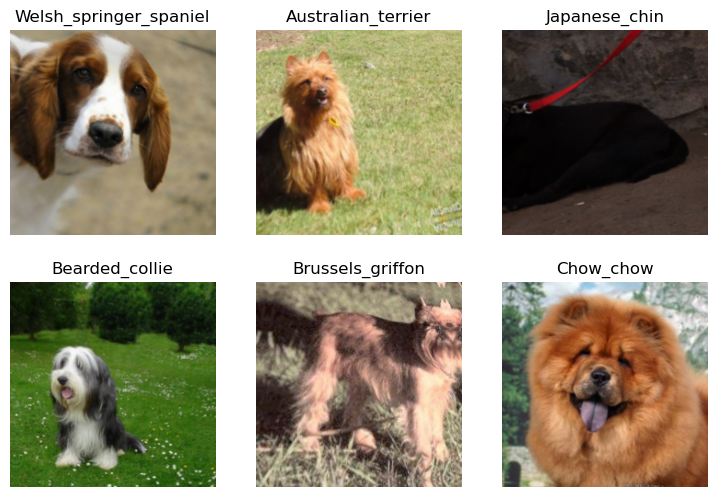

In [12]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(size=224)
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 159MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,2.352458,0.930988,0.290419,01:34


epoch,train_loss,valid_loss,error_rate,time
0,1.179090,0.617642,0.197605,01:31
1,0.978036,0.604374,0.196407,01:32
2,0.825523,0.621986,0.198204,01:33
3,0.682150,0.618383,0.194611,01:33
4,0.593238,0.523105,0.161078,01:34
5,0.435183,0.516196,0.165868,01:34
6,0.330546,0.466262,0.138323,01:34
7,0.232086,0.422549,0.136527,01:32
8,0.178206,0.414340,0.125749,01:33
9,0.158576,0.411632,0.126347,01:31


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

In [16]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,0.263108,0.588702,0.157485,01:32


epoch,train_loss,valid_loss,error_rate,time
0,0.225278,0.475396,0.149701,01:32
1,0.277615,0.619638,0.168263,01:32
2,0.304826,0.636023,0.170659,01:33
3,0.303008,0.608280,0.166467,01:33
4,0.266224,0.624897,0.165868,01:32
5,0.212957,0.567243,0.152695,01:32
6,0.155380,0.517745,0.141317,01:32
7,0.121020,0.464019,0.123952,01:33
8,0.096080,0.462041,0.131737,01:32
9,0.092649,0.461894,0.126347,01:33


In [17]:
learn.export("model2.pkl")

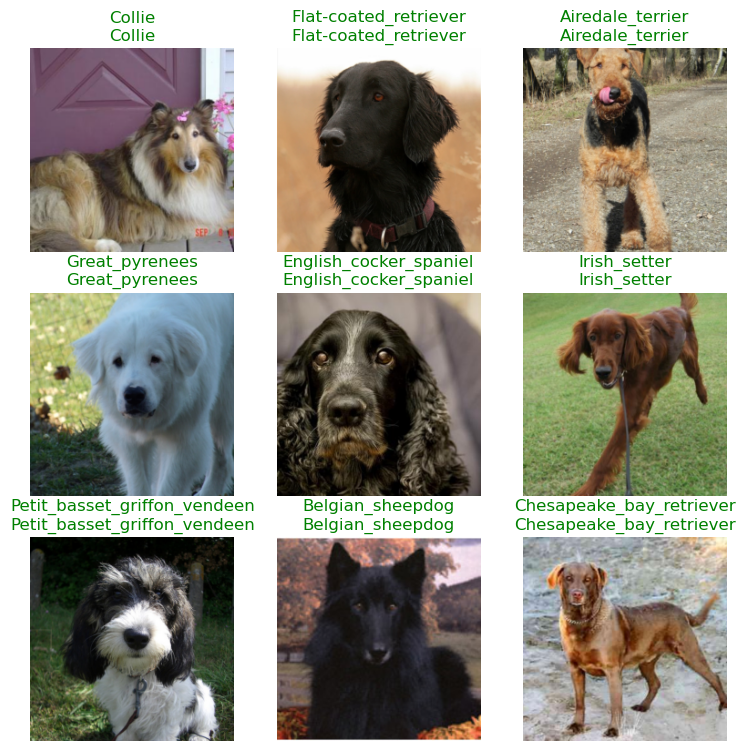

In [21]:
learn.show_results()

In [26]:
learn.dls.vocab

['Affenpinscher', 'Afghan_hound', 'Airedale_terrier', 'Akita', 'Alaskan_malamute', 'American_eskimo_dog', 'American_foxhound', 'American_staffordshire_terrier', 'American_water_spaniel', 'Anatolian_shepherd_dog', 'Australian_cattle_dog', 'Australian_shepherd', 'Australian_terrier', 'Basenji', 'Basset_hound', 'Beagle', 'Bearded_collie', 'Beauceron', 'Bedlington_terrier', 'Belgian_malinois', 'Belgian_sheepdog', 'Belgian_tervuren', 'Bernese_mountain_dog', 'Bichon_frise', 'Black_and_tan_coonhound', 'Black_russian_terrier', 'Bloodhound', 'Bluetick_coonhound', 'Border_collie', 'Border_terrier', 'Borzoi', 'Boston_terrier', 'Bouvier_des_flandres', 'Boxer', 'Boykin_spaniel', 'Briard', 'Brittany', 'Brussels_griffon', 'Bull_terrier', 'Bulldog', 'Bullmastiff', 'Cairn_terrier', 'Canaan_dog', 'Cane_corso', 'Cardigan_welsh_corgi', 'Cavalier_king_charles_spaniel', 'Chesapeake_bay_retriever', 'Chihuahua', 'Chinese_crested', 'Chinese_shar-pei', 'Chow_chow', 'Clumber_spaniel', 'Cocker_spaniel', 'Collie',

In [27]:
interp = Interpretation.from_learner(learn)

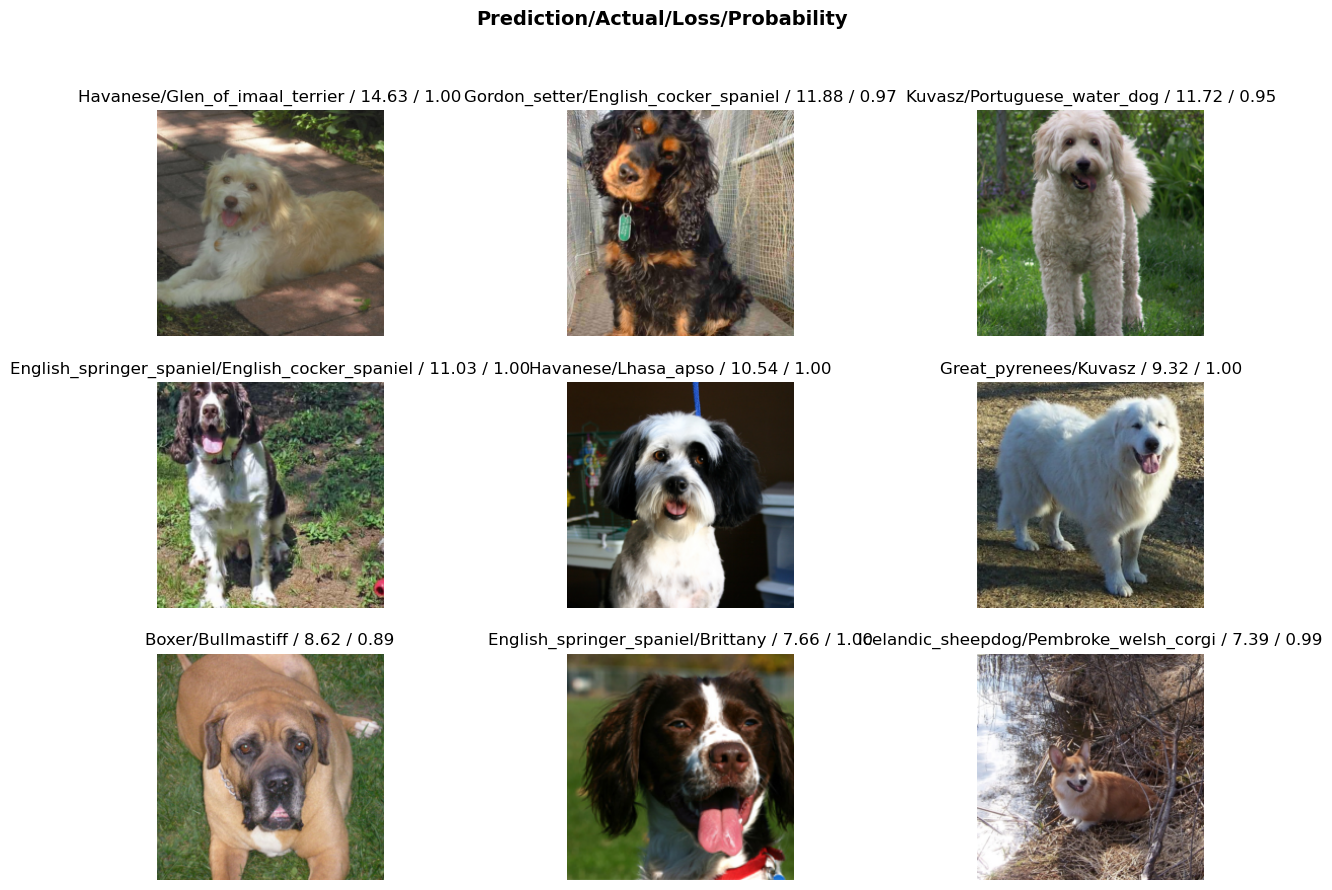

In [28]:
interp.plot_top_losses(9, figsize=(15,10))

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [18]:
urls = search_images('American Pit Bull Terrier photos', max_images=10)
for url in urls:
    print(url)

Searching for 'American Pit Bull Terrier photos'


/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


https://wallpapercave.com/wp/wp2048258.jpg
https://upload.wikimedia.org/wikipedia/commons/thumb/f/f6/004_American_Pit_Bull_Terrier.jpg/1200px-004_American_Pit_Bull_Terrier.jpg
https://wallpapercave.com/wp/wp2048266.jpg
https://animalsbreeds.com/wp-content/uploads/2014/12/American-Pit-Bull-Terrier-5.jpg
https://wallpapercave.com/wp/wp2048430.jpg
https://upload.wikimedia.org/wikipedia/commons/thumb/3/31/002_American_Pit_Bull_Terrier.jpg/1200px-002_American_Pit_Bull_Terrier.jpg
https://animalsbreeds.com/wp-content/uploads/2014/12/American-Pit-Bull-Terrier-6.jpg
https://allbigdogbreeds.com/wp-content/gallery/american-pit-bull-terrier/AmStaff3.jpg
https://animalsbreeds.com/wp-content/uploads/2014/12/American-Pit-Bull-Terrier-4.jpg
https://misanimales.com/wp-content/uploads/2014/12/american-pitbbull-terrier.jpg


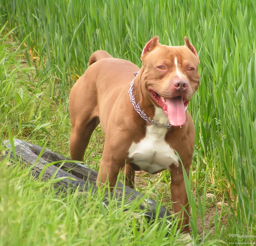

In [19]:
dest = 'dog_test.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256,256)

In [20]:
dog_breed,argprob,probs = learn.predict(PILImage.create('dog_test.jpg'))
print(f"This is a: {dog_breed}.")
print(f"Probability it's a {dog_breed}: {probs[argprob.item()]:.4f}")

This is a: American_staffordshire_terrier.
Probability it's a American_staffordshire_terrier: 0.8931


Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

Now it's your turn. Click "Copy & Edit" and try creating your own image classifier using your own image searches!

If you enjoyed this, please consider clicking the "upvote" button in the top-right -- it's very encouraging to us notebook authors to know when people appreciate our work.